In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz

In [58]:
datax = pd.read_excel("./QuadFormsData.xlsx", sheet_name="MultiAdjacenceyCompl")
data_np = datax.iloc[0:, 1:].to_numpy()
data_np[np.isnan(data_np)] = 0
data_np.shape

adj = data_np

In [59]:
mv_labels = datax.iloc[:, 0]
mv_labels_lst = [lb for lb in mv_labels]
mv_labels_actual = {}
mv_labels_numerical = {}
for i, lb in enumerate(mv_labels_lst):
    mv_labels_numerical[i] = str(i)
    ind = lb.find("Eq")
    if ind < 0: 
        ind = len(lb)
        qx = ""
    else:
        qx = lb[ind:]
    lbcite = "\\cite[" + qx + "]{" + lb[0:(ind)] + "}"
    mv_labels_actual[i] = lbcite
print(mv_labels_actual)

{0: '\\cite[]{khammassiNewAnalyticalApproximation2022}', 1: '\\cite[]{lavernyEstimationMultivariateGeneralized2021}', 2: '\\cite[]{tekinayMomentsQuadrivariateRayleigh2020}', 3: '\\cite[]{bithasNovelResultsMultivariate2019}', 4: '\\cite[]{wiegandSeriesApproximationsRayleigh2019}', 5: '\\cite[]{wiegandSeriesRepresentationMultidimensional2018}', 6: '\\cite[Eq8]{beaulieuNewSimplestExact2017}', 7: '\\cite[Eq13]{beaulieuNewSimplestExact2017}', 8: '\\cite[]{lasserreComputingGaussianExponential2017}', 9: '\\cite[]{royenNonCentralMultivariateChiSquare2016}', 10: '\\cite[]{beaulieuNovelRepresentationsBivariate2011}', 11: '\\cite[Eq14]{beaulieuNovelSimpleRepresentations2011}', 12: '\\cite[Eq18]{beaulieuNovelSimpleRepresentations2011}', 13: '\\cite[Eq20]{beaulieuNovelSimpleRepresentations2011}', 14: '\\cite[Eq22]{beaulieuNovelSimpleRepresentations2011}', 15: '\\cite[]{morales-jimenezDiagonalDistributionComplex2011}', 16: '\\cite[]{dharmawansaDiagonalDistributionComplex2009}', 17: '\\cite[]{dharmaw

In [60]:
rows, cols = np.where(adj == 1)
edges = zip(rows.tolist(), cols.tolist())
hand_gr = nx.DiGraph()
hand_gr.add_edges_from(edges)

edm = nx.algorithms.tree.branchings.Edmonds(hand_gr)
min_gr = edm.find_optimum(kind='max',style='aborescence')

min_pos = nx.nx_pydot.graphviz_layout(min_gr)

C:\Users\Mahmoud\AppData\Local\Temp\ipykernel_17836\3168973568.py:9: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  min_pos = nx.nx_pydot.graphviz_layout(min_gr)


In [53]:
# Just checking to see if I understand has_path that Mahmoud was searching
print(nx.has_path(min_gr, 0, 8))
print(nx.has_path(min_gr, 8, 0))
print(nx.has_path(min_gr, 3, 10))
print(nx.has_path(min_gr, 10, 12))
# So this seems to take the concept of direction into account which is what we need
print(nx.has_path(min_gr, 8, 24))

False
True
True
False
True


In [61]:
new_min_gr = hand_gr.copy()
for e in list(hand_gr.edges):
    gr_temp = new_min_gr.copy()
    gr_temp.remove_edge(e[0],e[1])
    if nx.has_path(gr_temp, e[0], e[1]):
        new_min_gr = gr_temp.copy()

print(len(hand_gr.edges))
print(len(new_min_gr.edges))        

164
45


C:\Users\Mahmoud\AppData\Local\Temp\ipykernel_17836\16167064.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos_min = nx.nx_pydot.graphviz_layout(new_min_gr, prog="dot", root=8)


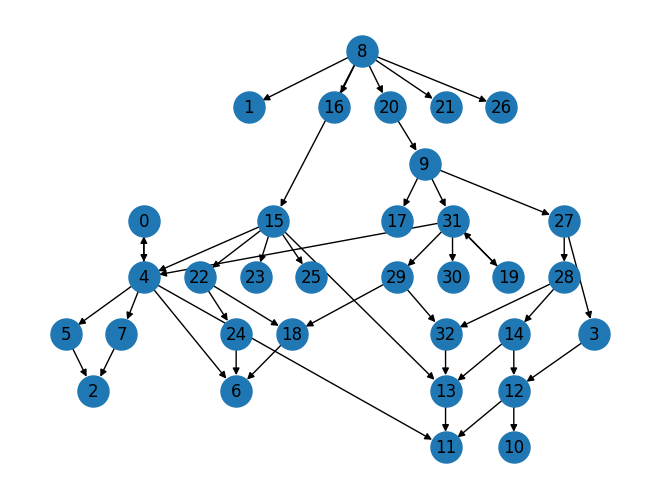

In [62]:
pos_min = nx.nx_pydot.graphviz_layout(new_min_gr, prog="dot", root=8)
nx.draw(new_min_gr, node_size=500, labels=mv_labels_numerical, with_labels=True, pos=pos_min)
plt.show()

In [63]:
# Can we rebuild the original graph
hand_gr_recon = new_min_gr.copy()
counter = 0
for i in hand_gr_recon.nodes:
    for j in hand_gr_recon.nodes:
        if nx.has_path(new_min_gr, i, j) and not hand_gr_recon.has_edge(i,j) and i != j:
            hand_gr_recon.add_edge(i,j)
            counter = counter + 1
print(len(new_min_gr.edges),len(hand_gr_recon.edges),counter)
# Yes, it rebuilds the original graph. PROBLEM SOLVED!!!!!!!!!!!!!

45 164 119


In [45]:
198 -33

165

In [6]:
print(len(rows), len(cols))
Nedges = len(rows)
minimal_graph_edges_count = 0
for i in range(Nedges):
    if nx.has_path(min_gr, rows[i], cols[i]):
        minimal_graph_edges_count += 1
print("Total Edges: {}\nMinimal Graph Edges: {}\nRemoved Edges: {}".format(
    Nedges, minimal_graph_edges_count, Nedges - minimal_graph_edges_count
))

165 165
Total Edges: 165
Minimal Graph Edges: 37
Removed Edges: 128


We now iterate through the `Nedges` and if  source node cannot reach the target node in the minimal graph then we add this edge to the original

In [7]:
# Can we ask a graph how many edges it has?
print(len(hand_gr.edges))
print(len(min_gr.edges))
print(hand_gr.is_directed())
print(nx.is_directed_acyclic_graph(hand_gr))

165
32
True
False


In [8]:
edges_to_reinsert = []
big_gr = min_gr.copy()
for i in range(Nedges):
    if not (nx.has_path(big_gr, rows[i], cols[i])):
        src_node = rows[i]
        dst_node = cols[i]
        e = ((src_node,dst_node),)
        big_gr.add_edges_from(e)

In [18]:
print(len(hand_gr.edges))
print(len(min_gr.edges))
print(len(big_gr.edges))

165
32
103


C:\Users\Mahmoud\AppData\Local\Temp\ipykernel_17836\2743026155.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos_min = nx.nx_pydot.graphviz_layout(min_gr, prog="dot", root=8)


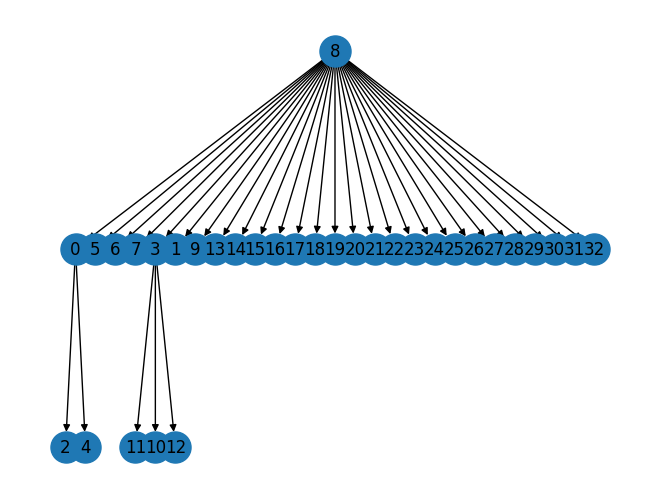

In [25]:
pos_min = nx.nx_pydot.graphviz_layout(min_gr, prog="dot", root=8)
nx.draw(min_gr, node_size=500, labels=mv_labels_numerical, with_labels=True, pos=pos_min)
plt.show()


C:\Users\Mahmoud\AppData\Local\Temp\ipykernel_17836\3656894797.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos_big = nx.nx_pydot.graphviz_layout(new_min_gr, prog="dot", root=8)


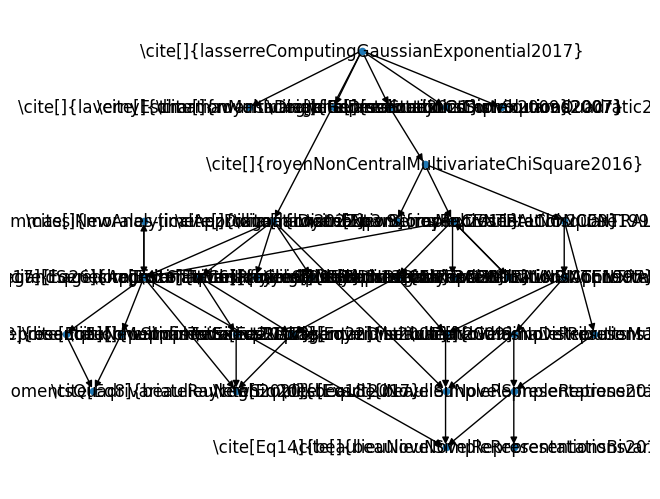

Writing 'latexstr1' (str) to file 'build/graph.tex'.


In [64]:
pos_big = nx.nx_pydot.graphviz_layout(new_min_gr, prog="dot", root=8)
nx.draw(new_min_gr, node_size=20, labels=mv_labels_actual, with_labels=True, pos=pos_big)
plt.show()
pos_big_scaled = {}
doc_wrapper = r'''\documentclass{{standalone}}
\usepackage{{tikz}}

\usepackage[backend=biber, sorting=ydnt, style=ieee, doi=true,isbn=false,url=true,backref=true,maxnames=6]{{biblatex}}
\addbibresource{{../MaximaCorrelatedRandoms.bib}}

\begin{{document}}
{content}
\end{{document}}
'''
for p in pos_big:
    pos_big_scaled[p] = (pos_big[p][0]/100, pos_big[p][1]/100)
latexstr1 = nx.to_latex(
    new_min_gr,
    node_label=mv_labels_actual,
    pos=pos_big_scaled,
    document_wrapper= doc_wrapper,#'\\documentclass{{standalone}}\n\\usepackage{{tikz}}\n\n\n\\begin{{document}}\n{content}\n\\end{{document}}',
    figure_wrapper='\n{content}\n'
)
%store latexstr1 >build/graph.tex

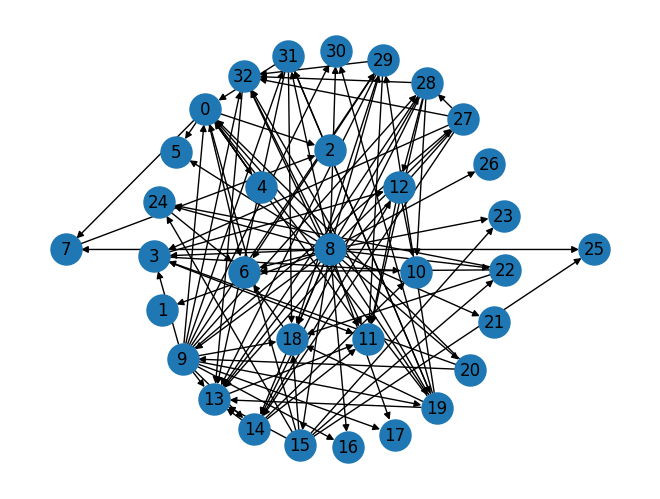

In [13]:
posx = nx.shell_layout(big_gr, [[8], [2,4,6,18,11,10,12], [0,5,24,3,1,9,13,14,15,16,17,19,20,21,22,23,26,27,28,29,30,31,32], [7,25]])
nx.draw(big_gr, node_size=500, labels=mv_labels_numerical, with_labels=True, pos=posx)
plt.show()

In [1]:
pos_hand_big = nx.nx_pydot.graphviz_layout(hand_gr, prog="dot", root=8)
nx.draw(big_gr, node_size=250, labels=mv_labels_actual, with_labels=True, pos=pos_hand_big)
plt.show()

NameError: name 'nx' is not defined